# Tutorial 5 (JAX): Inception, ResNet and DenseNet

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)


**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.ipynb)   
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial5)   
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.
    
</div>

---

**Speed comparison**: We note the training times for all models in the PyTorch and the JAX implementation below (PyTorch v1.11, JAX v0.3.13). The models were trained on the same hardware (NVIDIA RTX3090, 24 core CPU) and we slightly adjusted the tutorials to use the exact same training settings (200 epochs, data loading parameters, evaluation schedule, etc.). Overall, the JAX implementation is about *2.5-3.4x faster* than PyTorch! However, with larger models, larger batch sizes, or smaller GPUs, the speed up is expected to become considerably smaller.
    
| Models                |   PyTorch   |     JAX     |
|-----------------------|:-----------:|:-----------:|
| GoogleNet             | 53min 50sec | 16min 10sec |
| ResNet                | 20min 47sec |  7min 51sec |
| Pre-Activation ResNet | 20min 57sec |  8min 25sec |
| DenseNet              | 49min 23sec |  20min 1sec |

---

In this tutorial, we will implement and discuss variants of modern CNN architectures. There have been many different architectures been proposed over the past few years. Some of the most impactful ones, and still relevant today, are the following: [GoogleNet](https://arxiv.org/abs/1409.4842)/Inception architecture (winner of ILSVRC 2014), [ResNet](https://arxiv.org/abs/1512.03385) (winner of ILSVRC 2015), and [DenseNet](https://arxiv.org/abs/1608.06993) (best paper award CVPR 2017). All of them were state-of-the-art models when being proposed, and the core ideas of these networks are the foundations for most current state-of-the-art architectures. Thus, it is important to understand these architectures in detail and learn how to implement them. 

Let's start with importing our standard libraries here.

In [1]:
## Standard libraries
import os
import numpy as np
from PIL import Image
from typing import Any
from collections import defaultdict
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

We will use the same path variables `DATASET_PATH` and `CHECKPOINT_PATH` as in the previous tutorials. Adjust the paths if necessary.

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial5_jax"

print("Device:", jax.devices()[0])

Device: gpu:0


We also have pretrained models and TensorBoards (more on this later) for this tutorial, and download them below.

In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "PreActResNet.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/PreActResNet/events.out.tfevents.preactresnet",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Throughout this tutorial, we will train and evaluate the models on the CIFAR10 dataset. This allows you to compare the results obtained here with the model you have implemented in the first assignment. As we have learned from the previous tutorial about initialization, it is important to have the data preprocessed with a zero mean. Therefore, as a first step, we will calculate the mean and standard deviation of the CIFAR dataset:

In [4]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


We will use this information to normalize our data accordingly. Additionally, we will use transformations from the package `torchvision` to implement data augmentations during training. This reduces the risk of overfitting and helps CNNs to generalize better. Specifically, we will apply two random augmentations. 

First, we will flip each image horizontally by a chance of 50% (`transforms.RandomHorizontalFlip`). The object class usually does not change when flipping an image, and we don't expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called `transforms.RandomResizedCrop`. This transformation crops the image in a small range, eventually changing the aspect ratio, and scaling it back afterward to the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same. 

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.

In [5]:
# Transformations applied on each image => bring them into a numpy array
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

    
test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set, 
                               batch_size=128, 
                               shuffle=True, 
                               drop_last=True, 
                               collate_fn=numpy_collate, 
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set, 
                               batch_size=128, 
                               shuffle=False, 
                               drop_last=False, 
                               collate_fn=numpy_collate, 
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set, 
                               batch_size=128, 
                               shuffle=False, 
                               drop_last=False, 
                               collate_fn=numpy_collate, 
                               num_workers=4,
                               persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


To verify that our normalization works, we can print out the mean and standard deviation of the single batch. The mean should be close to 0 and the standard deviation close to 1 for each channel:

In [6]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(axis=(0,1,2)))
print("Batch std", imgs.std(axis=(0,1,2)))

Batch mean [-0.05225317 -0.06281322 -0.11905593]
Batch std [0.95375352 0.92699525 0.91463391]


Finally, let's visualize a few images from the training set, and how they look like after random data augmentation: 

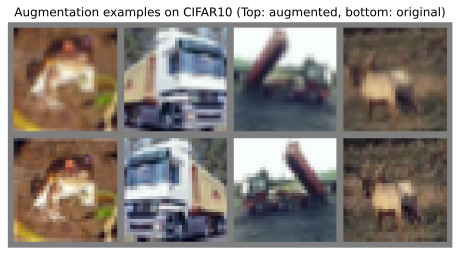

In [7]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

imgs = np.stack(images + orig_images, axis=0)
imgs = torch.from_numpy(imgs).permute(0, 3, 1, 2)
img_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10 (Top: augmented, bottom: original)")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Trainer Module

In the [PyTorch version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) of this tutorial, we would now introduce the framework [PyTorch Lightning](https://www.pytorchlightning.ai/) which simplifies the overall training of a model. So far (June 2022), there is no clear equivalent of it for JAX. Some basic training functionalities are implemented in `flax.training` ([documentation](https://flax.readthedocs.io/en/latest/flax.training.html)), and predefined training modules are implemented in `trax` ([documentation](https://trax-ml.readthedocs.io/en/latest/)), but neither provide a complete, flexible training package yet like PyTorch Lightning. Hence, we need to write our own small training loop. 

For this, we take inspiration from PyTorch Lightning and build a trainer module/object with the following main functionalities:

1. *Storing model and parameters*: In order to train multiple models with different hyperparameters, the trainer module creates an instance of the model class, and keeps the parameters in the same class. This way, we can easily apply a model with its parameters on new inputs.
2. *Initialization of model and training state*: During initialization of the trainer, we initialize the model parameters and a new train state, which includes the optimizer and possible learning rate schedulers.
3. *Training, validation and test loops*: Similar to PyTorch Lightning, we implement simple training, validation and test loops, where subclasses of this trainer could overwrite the respective training, validation or test steps. Since in this tutorial, all models will have the same objective, i.e. classification on CIFAR10, we will pre-specify them in the trainer module below.
4. *Logging, saving and loading of models*: To keep track of the training, we implement functionalities to log the training progress and save the best model on the validation set. Afterwards, this model can be loaded from the disk. 

Before starting to implement a trainer module with these functionalities, we need to take one prior step. The networks we will implement in this tutorial use BatchNormalization, which carries an exponential average of the prior batch statistics (mean and std) to apply during evaluation. In PyTorch, this is simply tracked by an object attribute of an object of the class `nn.BatchNorm2d`, but in JAX, we only work with functions. Hence, we need to take care of the batch statistics ourselves, similar to the parameters, and enter them during every forward pass. To simplify this a little, we overwrite the `train_state.TrainState` class of Flax by adding a field for the batch statistics:

In [8]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    batch_stats: Any

With this, the training state contains both the training parameters and the batch statistics, which makes it easier to keep everything in one place.

Now that the batch statistics are sorted out, we can implement our full training module:

In [9]:
class TrainerModule:

    def __init__(self, 
                 model_name : str, 
                 model_class : nn.Module, 
                 model_hparams : dict, 
                 optimizer_name : str, 
                 optimizer_hparams : dict, 
                 exmp_imgs : Any, 
                 seed=42):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.
        
        Inputs:
            model_name - String of the class name, used for logging and saving
            model_class - Class implementing the neural network
            model_hparams - Hyperparameters of the model, used as input to model constructor
            optimizer_name - String of the optimizer name, supporting ['sgd', 'adam', 'adamw']
            optimizer_hparams - Hyperparameters of the optimizer, including learning rate as 'lr'
            exmp_imgs - Example imgs, used as input to initialize the model
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.model_name = model_name
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, batch_stats, batch, train):
            imgs, labels = batch
            # Run model. During training, we need to update the BatchNorm statistics.
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats}, 
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, new_model_state)
        # Training function
        def train_step(state, batch):
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)  
            loss, acc, new_model_state = ret[0], *ret[1]
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
            return state, loss, acc
        # Eval function
        def eval_step(state, batch):
            # Return the accuracy for a single batch
            _, (acc, _) = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = jax.random.PRNGKey(self.seed)
        variables = self.model.init(init_rng, exmp_imgs, train=True)
        self.init_params, self.init_batch_stats = variables['params'], variables['batch_stats']
        self.state = None
        
    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # Initialize learning rate schedule and optimizer
        if self.optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif self.optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif self.optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.optimizer_hparams.pop('lr'),
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.85): 0.1}
        )
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip(1.0)]
        if opt_class == optax.sgd and 'weight_decay' in self.optimizer_hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(self.optimizer_hparams.pop('weight_decay')))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **self.optimizer_hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.model.apply, 
                                       params=self.init_params if self.state is None else self.state.params,
                                       batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss, acc = self.train_step(self.state, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            acc = self.eval_step(self.state, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, 
                                    target={'params': self.state.params, 
                                            'batch_stats': self.state.batch_stats}, 
                                    step=step,
                                   overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        self.state = TrainState.create(apply_fn=self.model.apply, 
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       tx=self.state.tx if self.state else optax.sgd(0.1)   # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

Next, we can use this trainer module to create a compact training function:

In [10]:
def train_classifier(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

Finally, we can focus on the Convolutional Neural Networks we want to implement today: GoogleNet, ResNet, and DenseNet.

## Inception

The [GoogleNet](https://arxiv.org/abs/1409.4842), proposed in 2014, won the ImageNet Challenge because of its usage of the Inception modules. In general, we will mainly focus on the concept of Inception in this tutorial instead of the specifics of the GoogleNet, as based on Inception, there have been many follow-up works ([Inception-v2](https://arxiv.org/abs/1512.00567), [Inception-v3](https://arxiv.org/abs/1512.00567), [Inception-v4](https://arxiv.org/abs/1602.07261), [Inception-ResNet](https://arxiv.org/abs/1602.07261),...). The follow-up works mainly focus on increasing efficiency and enabling very deep Inception networks. However, for a fundamental understanding, it is sufficient to look at the original Inception block. 

An Inception block applies four convolution blocks separately on the same feature map: a 1x1, 3x3, and 5x5 convolution, and a max pool operation. This allows the network to look at the same data with different receptive fields. Of course, learning only 5x5 convolution would be theoretically more powerful. However, this is not only more computation and memory heavy but also tends to overfit much easier. The overall inception block looks like below (figure credit - [Szegedy et al.](https://arxiv.org/abs/1409.4842)):

<center width="100%"><img src="../../tutorial5/inception_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

The additional 1x1 convolutions before the 3x3 and 5x5 convolutions are used for dimensionality reduction. This is especially crucial as the feature maps of all branches are merged afterward, and we don't want any explosion of feature size. As 5x5 convolutions are 25 times more expensive than 1x1 convolutions, we can save a lot of computation and parameters by reducing the dimensionality before the large convolutions.

We can now try to implement the Inception Block ourselves:

In [11]:
googlenet_kernel_init = nn.initializers.kaiming_normal()

class InceptionBlock(nn.Module):
    c_red : dict  # Dictionary of reduced dimensionalities with keys "1x1", "3x3", "5x5", and "max"
    c_out : dict  # Dictionary of output feature sizes with keys "1x1", "3x3", "5x5", and "max"
    act_fn : callable   # Activation function
    
    @nn.compact
    def __call__(self, x, train=True):
        # 1x1 convolution branch
        x_1x1 = nn.Conv(self.c_out["1x1"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_1x1 = nn.BatchNorm()(x_1x1, use_running_average=not train)
        x_1x1 = self.act_fn(x_1x1)
        
        # 3x3 convolution branch
        x_3x3 = nn.Conv(self.c_red["3x3"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        x_3x3 = nn.Conv(self.c_out["3x3"], kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x_3x3)
        x_3x3 = nn.BatchNorm()(x_3x3, use_running_average=not train)
        x_3x3 = self.act_fn(x_3x3)
        
        # 5x5 convolution branch
        x_5x5 = nn.Conv(self.c_red["5x5"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        x_5x5 = nn.Conv(self.c_out["5x5"], kernel_size=(5, 5), kernel_init=googlenet_kernel_init, use_bias=False)(x_5x5)
        x_5x5 = nn.BatchNorm()(x_5x5, use_running_average=not train)
        x_5x5 = self.act_fn(x_5x5)
        
        # Max-pool branch
        x_max = nn.max_pool(x, (3, 3), strides=(2, 2))
        x_max = nn.Conv(self.c_out["max"], kernel_size=(1, 1), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x_max = nn.BatchNorm()(x_max, use_running_average=not train)
        x_max = self.act_fn(x_max)
        
        x_out = jnp.concatenate([x_1x1, x_3x3, x_5x5, x_max], axis=-1)
        return x_out

The GoogleNet architecture consists of stacking multiple Inception blocks with occasional max pooling to reduce the height and width of the feature maps. The original GoogleNet was designed for image sizes of ImageNet (224x224 pixels) and had almost 7 million parameters. As we train on CIFAR10 with image sizes of 32x32, we don't require such a heavy architecture, and instead, apply a reduced version. The number of channels for dimensionality reduction and output per filter (1x1, 3x3, 5x5, and max pooling) need to be manually specified and can be changed if interested. The general intuition is to have the most filters for the 3x3 convolutions, as they are powerful enough to take the context into account while requiring almost a third of the parameters of the 5x5 convolution. 

In [12]:
class GoogleNet(nn.Module):
    num_classes : int
    act_fn : callable
        
    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(64, kernel_size=(3, 3), kernel_init=googlenet_kernel_init, use_bias=False)(x)
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
            
        # Stacking inception blocks
        inception_blocks = [
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 32x32 => 16x16
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.act_fn),
            lambda inp: nn.max_pool(inp, (3, 3), strides=(2, 2)),  # 16x16 => 8x8
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn),
            InceptionBlock(c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.act_fn)
        ]
        for block in inception_blocks:
            x = block(x, train=train) if isinstance(block, InceptionBlock) else block(x)
        
        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

The training of the model is handled by our previously implemented training function, and we just have to define the command to start. Note that we train for 200 epochs, which takes about 15mins on a RTX3090. We would recommend using the saved models and train your own model if you are interested. 

In [13]:
googlenet_trainer, googlenet_results = train_classifier(model_class=GoogleNet,
                                                        model_name="GoogleNet",
                                                        model_hparams={"num_classes": 10,
                                                                       "act_fn": nn.relu},
                                                        optimizer_name="adamw",
                                                        optimizer_hparams={"lr": 1e-3,
                                                                           "weight_decay": 1e-4},
                                                        exmp_imgs=jax.device_put(
                                                            next(iter(train_loader))[0]),
                                                        num_epochs=200)

We will compare the results later in the notebooks, but we can already print them here for a first glance:

In [14]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'val': 0.9022000432014465, 'test': 0.8911000490188599}


### Tensorboard log

For logging our results, we have used TensorBoard. To give you a better intuition of what TensorBoard can be used for, we can look at the board that our training of the GoogleNet has generated. TensorBoard provides an inline functionality for Jupyter notebooks, and we use it here:

In [15]:
# Load tensorboard extension
%load_ext tensorboard

In [16]:
# Opens tensorboard in notebook.
%tensorboard --logdir $CHECKPOINT_PATH/tensorboards/GoogleNet/

<center width="100%"><img src="tensorboard_screenshot_GoogleNet.png" width="1000px"></center>

TensorBoard is organized in multiple tabs. The main tab is the scalar tab where we can log the development of single numbers. For example, we have plotted the training loss, accuracy, learning rate, etc. If we look at the training or validation accuracy, we can really see the impact of using a learning rate scheduler. Reducing the learning rate gives our model a nice increase in training performance. Similarly, when looking at the training loss, we see a sudden decrease at this point. However, the high numbers on the training set compared to validation indicate that our model was overfitting which is inevitable for such large networks.

## ResNet

The [ResNet](https://arxiv.org/abs/1512.03385) paper is one of the  [most cited AI papers](https://www.natureindex.com/news-blog/google-scholar-reveals-most-influential-papers-research-citations-twenty-twenty), and has been the foundation for neural networks with more than 1,000 layers. Despite its simplicity, the idea of residual connections is highly effective as it supports stable gradient propagation through the network. Instead of modeling $x_{l+1}=F(x_{l})$, we model $x_{l+1}=x_{l}+F(x_{l})$ where $F$ is a non-linear mapping (usually a sequence of NN modules likes convolutions, activation functions, and normalizations). If we do backpropagation on such residual connections, we obtain:

$$\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}}$$

The bias towards the identity matrix guarantees a stable gradient propagation being less effected by $F$ itself. There have been many variants of ResNet proposed, which mostly concern the function $F$, or operations applied on the sum. In this tutorial, we look at two of them: the original ResNet block, and the [Pre-Activation ResNet block](https://arxiv.org/abs/1603.05027). We visually compare the blocks below (figure credit - [He et al.](https://arxiv.org/abs/1603.05027)):

<center width="100%"><img src="../../tutorial5/resnet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="300px"/></center>

The original ResNet block applies a non-linear activation function, usually ReLU, after the skip connection. In contrast, the pre-activation ResNet block applies the non-linearity at the beginning of $F$. Both have their advantages and disadvantages. For very deep network, however, the pre-activation ResNet has shown to perform better as the gradient flow is guaranteed to have the identity matrix as calculated above, and is not harmed by any non-linear activation applied to it. For comparison, in this notebook, we implement both ResNet types as shallow networks.

Let's start with the original ResNet block. The visualization above already shows what layers are included in $F$. One special case we have to handle is when we want to reduce the image dimensions in terms of width and height. The basic ResNet block requires $F(x_{l})$ to be of the same shape as $x_{l}$. Thus, we need to change the dimensionality of $x_{l}$ as well before adding to $F(x_{l})$. The original implementation used an identity mapping with stride 2 and padded additional feature dimensions with 0. However, the more common implementation is to use a 1x1 convolution with stride 2 as it allows us to change the feature dimensionality while being efficient in parameter and computation cost. The code for the ResNet block is relatively simple, and shown below:

In [17]:
# Conv initialized with kaiming int, but uses fan-out instead of fan-in mode
# Fan-out focuses on the gradient distribution, and is commonly used in ResNets
resnet_kernel_init = nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal')

class ResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.Conv(self.c_out, kernel_size=(3, 3), 
                    strides=(1, 1) if not self.subsample else (2, 2), 
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(x)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3), 
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        
        if self.subsample:
            x = nn.Conv(self.c_out, kernel_size=(1, 1), strides=(2, 2), kernel_init=resnet_kernel_init)(x)
        
        x_out = self.act_fn(z + x)
        return x_out

The second block we implement is the pre-activation ResNet block. For this, we have to change the order of layers, and do not apply an activation function on the output. Additionally, the downsampling operation has to apply a non-linearity as well as the input, $x_l$, has not been processed by a non-linearity yet. Hence, the block looks as follows:

In [18]:
class PreActResNetBlock(ResNetBlock):
    
    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.BatchNorm()(x, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3), 
                    strides=(1, 1) if not self.subsample else (2, 2), 
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3), 
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        
        if self.subsample:
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)
            x = nn.Conv(self.c_out, 
                        kernel_size=(1, 1), 
                        strides=(2, 2), 
                        kernel_init=resnet_kernel_init,
                        use_bias=False)(x)
        
        x_out = z + x
        return x_out

The overall ResNet architecture consists of stacking multiple ResNet blocks, of which some are downsampling the input. When talking about ResNet blocks in the whole network, we usually group them by the same output shape. Hence, if we say the ResNet has `[3,3,3]` blocks, it means that we have 3 times a group of 3 ResNet blocks, where a subsampling is taking place in the fourth and seventh block. The ResNet with `[3,3,3]` blocks on CIFAR10 is visualized below.

<center width="100%"><img src="../../tutorial5/resnet_notation.svg" width="500px"></center>

The three groups operate on the resolutions $32\times32$, $16\times16$ and $8\times8$ respectively. The blocks in orange denote ResNet blocks with downsampling. The same notation is used by many other implementations such as in the [torchvision library](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18) from PyTorch or [flaxmodels](https://github.com/matthias-wright/flaxmodels) (pretrained ResNets and more for JAX). Thus, our code looks as follows:

In [19]:
class ResNet(nn.Module):
    num_classes : int
    act_fn : callable
    block_class : nn.Module
    num_blocks : tuple = (3, 3, 3)
    c_hidden : tuple = (16, 32, 64)
        
    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(self.c_hidden[0], kernel_size=(3, 3), kernel_init=resnet_kernel_init, use_bias=False)(x)
        if self.block_class == ResNetBlock:  # If pre-activation block, we do not apply non-linearities yet
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)
        
        # Creating the ResNet blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)
                # ResNet block
                x = self.block_class(c_out=self.c_hidden[block_idx],
                                     act_fn=self.act_fn,
                                     subsample=subsample)(x, train=train)
        
        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

Finally, we can train our ResNet models. One difference to the GoogleNet training is that we explicitly use SGD with Momentum as optimizer instead of Adam. Adam often leads to a slightly worse accuracy on plain, shallow ResNets. It is not 100% clear why Adam performs worse in this context, but one possible explanation is related to ResNet's loss surface. ResNet has been shown to produce smoother loss surfaces than networks without skip connection (see [Li et al., 2018](https://arxiv.org/pdf/1712.09913.pdf) for details). A possible visualization of the loss surface with/out skip connections is below (figure credit - [Li et al.](https://arxiv.org/pdf/1712.09913.pdf)):

<center width="100%"><img src="../../tutorial5/resnet_loss_surface.svg" style="display: block; margin-left: auto; margin-right: auto;" width="600px"/></center>

The $x$ and $y$ axis shows a projection of the parameter space, and the $z$ axis shows the loss values achieved by different parameter values. On smooth surfaces like the one on the right, we might not require an adaptive learning rate as Adam provides. Instead, Adam can get stuck in local optima while SGD finds the wider minima that tend to generalize better.
However, to answer this question in detail, we would need an extra tutorial because it is not easy to answer. For now, we conclude: for ResNet architectures, consider the optimizer to be an important hyperparameter, and try training with both Adam and SGD. Let's train the model below with SGD:

In [20]:
resnet_trainer, resnet_results = train_classifier(model_name="ResNet",
                                                  model_class=ResNet,
                                                  model_hparams={"num_classes": 10,
                                                                 "c_hidden": (16, 32, 64),
                                                                 "num_blocks": (3, 3, 3),
                                                                 "act_fn": nn.relu,
                                                                 "block_class": ResNetBlock},
                                                  optimizer_name="SGD",
                                                  optimizer_hparams={"lr": 0.1,
                                                                     "momentum": 0.9,
                                                                     "weight_decay": 1e-4},
                                                  exmp_imgs=jax.device_put(
                                                      next(iter(train_loader))[0]),
                                                  num_epochs=200)

Let's also train the pre-activation ResNet as comparison:

In [21]:
preactresnet_trainer, preactresnet_results = train_classifier(model_name="PreActResNet",
                                                              model_class=ResNet,
                                                              model_hparams={"num_classes": 10,
                                                                             "c_hidden": (16, 32, 64),
                                                                             "num_blocks": (3, 3, 3),
                                                                             "act_fn": nn.relu,
                                                                             "block_class": PreActResNetBlock},
                                                              optimizer_name="SGD",
                                                              optimizer_hparams={"lr": 0.1,
                                                                                 "momentum": 0.9,
                                                                                 "weight_decay": 1e-4},
                                                              exmp_imgs=jax.device_put(
                                                                  next(iter(train_loader))[0]),
                                                              num_epochs=200)

### Tensorboard log

Similarly to our GoogleNet model, we also have a TensorBoard log for the ResNet model. We can open it below.

In [22]:
# Opens tensorboard in notebook. Feel free to change "ResNet" to "PreActResNet"
%tensorboard --logdir $CHECKPOINT_PATH/tensorboards/ResNet/ --port 6007

<center width="100%"><img src="tensorboard_screenshot_ResNet.png" width="1000px"></center>

Feel free to explore the TensorBoard yourself, including the computation graph. In general, we can see that with SGD, the ResNet has a higher training loss than the GoogleNet in the first stage of the training. After reducing the learning rate however, the model achieves even higher validation accuracies. We compare the precise scores at the end of the notebook.

## DenseNet

[DenseNet](https://arxiv.org/abs/1608.06993) is another architecture for enabling very deep neural networks and takes a slightly different perspective on residual connections. Instead of modeling the difference between layers, DenseNet considers residual connections as a possible way to reuse features across layers, removing any necessity to learn redundant feature maps. If we go deeper into the network, the model learns abstract features to recognize patterns. However, some complex patterns consist of a combination of abstract features (e.g. hand, face, etc.), and low-level features (e.g. edges, basic color, etc.). To find these low-level features in the deep layers, standard CNNs have to learn copy such feature maps, which wastes a lot of parameter complexity. DenseNet provides an efficient way of reusing features by having each convolution depends on all previous input features, but add only a small amount of filters to it. See the figure below for an illustration (figure credit - [Hu et al.](https://arxiv.org/abs/1608.06993)):

<center width="100%"><img src="../../tutorial5/densenet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

The last layer, called the transition layer, is responsible for reducing the dimensionality of the feature maps in height, width, and channel size. Although those technically break the identity backpropagation, there are only a few in a network so that it doesn't affect the gradient flow much. 

We split the implementation of the layers in DenseNet into three parts: a `DenseLayer`, and a `DenseBlock`, and a `TransitionLayer`. The module `DenseLayer` implements a single layer inside a dense block. It applies a 1x1 convolution for dimensionality reduction with a subsequential 3x3 convolution. The output channels are concatenated to the originals and returned. Note that we apply the Batch Normalization as the first layer of each block. This allows slightly different activations for the same features to different layers, depending on what is needed. Overall, we can implement it as follows:

In [23]:
densenet_kernel_init = nn.initializers.kaiming_normal()

class DenseLayer(nn.Module):
    bn_size : int  # Bottleneck size (factor of growth rate) for the output of the 1x1 convolution
    growth_rate : int  # Number of output channels of the 3x3 convolution
    act_fn : callable  # Activation function
        
    @nn.compact
    def __call__(self, x, train=True):
        z = nn.BatchNorm()(x, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.bn_size * self.growth_rate, 
                    kernel_size=(1, 1), 
                    kernel_init=densenet_kernel_init, 
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.growth_rate, 
                    kernel_size=(3, 3), 
                    kernel_init=densenet_kernel_init, 
                    use_bias=False)(z)
        x_out = jnp.concatenate([x, z], axis=-1)
        return x_out

The module `DenseBlock` summarizes multiple dense layers applied in sequence. Each dense layer takes as input the original input concatenated with all previous layers' feature maps:

In [24]:
class DenseBlock(nn.Module):
    num_layers : int  # Number of dense layers to apply in the block
    bn_size : int  # Bottleneck size to use in the dense layers
    growth_rate : int  # Growth rate to use in the dense layers
    act_fn : callable  # Activation function to use in the dense layers
    
    @nn.compact
    def __call__(self, x, train=True):
        for _ in range(self.num_layers):
            x = DenseLayer(bn_size=self.bn_size,
                           growth_rate=self.growth_rate,
                           act_fn=self.act_fn)(x, train=train)
        return x

Finally, the `TransitionLayer` takes as input the final output of a dense block and reduces its channel dimensionality using a 1x1 convolution. To reduce the height and width dimension, we take a slightly different approach than in ResNet and apply an average pooling with kernel size 2 and stride 2. This is because we don't have an additional connection to the output that would consider the full 2x2 patch instead of a single value. Besides, it is more parameter efficient than using a 3x3 convolution with stride 2. Thus, the layer is implemented as follows:

In [25]:
class TransitionLayer(nn.Module):
    c_out : int  # Output feature size
    act_fn : callable  # Activation function
        
    @nn.compact
    def __call__(self, x, train=True):
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = nn.Conv(self.c_out, 
                    kernel_size=(1, 1), 
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(x)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        return x

Now we can put everything together and create our DenseNet. To specify the number of layers, we use a similar notation as in ResNets and pass on a list of ints representing the number of layers per block. After each dense block except the last one, we apply a transition layer to reduce the dimensionality by 2. 

In [26]:
class DenseNet(nn.Module):
    num_classes : int
    act_fn : callable = nn.relu
    num_layers : tuple = (6, 6, 6, 6)
    bn_size : int = 2
    growth_rate : int = 16
    
    @nn.compact
    def __call__(self, x, train=True):
        c_hidden = self.growth_rate * self.bn_size  # The start number of hidden channels
        
        x = nn.Conv(c_hidden,
                    kernel_size=(3, 3),
                    kernel_init=densenet_kernel_init)(x)
        
        for block_idx, num_layers in enumerate(self.num_layers):
            x = DenseBlock(num_layers=num_layers,
                           bn_size=self.bn_size,
                           growth_rate=self.growth_rate,
                           act_fn=self.act_fn)(x, train=train)
            c_hidden += num_layers * self.growth_rate
            if block_idx < len(self.num_layers)-1:  # Don't apply transition layer on last block
                x = TransitionLayer(c_out=c_hidden//2,
                                    act_fn=self.act_fn)(x, train=train)
                c_hidden //= 2
        
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

Lastly, we train our network. In contrast to ResNet, DenseNet does not show any issues with Adam, and hence we train it with this optimizer. The other hyperparameters are chosen to result in a network with a similar parameter size as the ResNet and GoogleNet. Commonly, when designing very deep networks, DenseNet is more parameter efficient than ResNet while achieving a similar or even better performance.

In [27]:
densenet_trainer, densenet_results = train_classifier(model_name="DenseNet",
                                                      model_class=DenseNet,
                                                      model_hparams={"num_classes": 10,
                                                                     "num_layers": [6, 6, 6, 6],
                                                                     "bn_size": 2,
                                                                     "growth_rate": 16,
                                                                     "act_fn": nn.relu},
                                                      optimizer_name="adamw",
                                                      optimizer_hparams={"lr": 1e-3,
                                                                         "weight_decay": 1e-4},
                                                      exmp_imgs=jax.device_put(
                                                          next(iter(train_loader))[0]),
                                                      num_epochs=200)

### Tensorboard log

Finally, we also have another TensorBoard for the DenseNet training. We take a look at it below:

In [28]:
# Opens tensorboard in notebook.
%tensorboard --logdir $CHECKPOINT_PATH/tensorboards/DenseNet/ --port 6008

<center width="100%"><img src="tensorboard_screenshot_DenseNet.png" width="1000px"></center>

The overall course of the validation accuracy and training loss resemble the training of GoogleNet, which is also related to training the network with Adam. Feel free to explore the training metrics yourself.

## Conclusion and Comparison

After discussing each model separately, and training all of them, we can finally compare them. First, let's organize the results of all models in a table:

In [29]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [30]:
import tabulate
from IPython.display import display, HTML
all_models = [
    ("GoogleNet", googlenet_results, googlenet_trainer),
    ("ResNet", resnet_results, resnet_trainer),
    ("PreActResNet", preactresnet_results, preactresnet_trainer),
    ("DenseNet", densenet_results, densenet_trainer)
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in jax.tree_leaves(model.state.params)]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])))

Model,Val Accuracy,Test Accuracy,Num Parameters
GoogleNet,90.22%,89.11%,"259,338"
ResNet,91.84%,91.00%,"272,378"
PreActResNet,91.76%,90.65%,"272,250"
DenseNet,90.62%,90.43%,"239,146"


First of all, we see that all models are performing reasonably well. Simple models as you have implemented them in the practical achieve considerably lower performance, which is beside the lower number of parameters also attributed to the architecture design choice. GoogleNet is the model to obtain the lowest performance on the validation and test set, although it is very close to DenseNet. A proper hyperparameter search over all the channel sizes in GoogleNet would likely improve the accuracy of the model to a similar level, but this is also expensive given a large number of hyperparameters. ResNet outperforms both DenseNet and GoogleNet by more than 1% on the validation set, while there is a minor difference between both versions, original and pre-activation. We can conclude that for shallow networks, the place of the activation function does not seem to be crucial, although papers have reported the contrary for very deep networks (e.g. [He et al.](https://arxiv.org/abs/1603.05027)). 

In general, we can conclude that ResNet is a simple, but powerful architecture. If we would apply the models on more complex tasks with larger images and more layers inside the networks, we would likely see a bigger gap between GoogleNet and skip-connection architectures like ResNet and DenseNet. A comparison with deeper models on CIFAR10 can be for example found [here](https://github.com/kuangliu/pytorch-cifar). Interestingly, DenseNet outperforms the original ResNet on their setup but comes closely behind the Pre-Activation ResNet. The best model, a Dual Path Network ([Chen et. al](https://arxiv.org/abs/1707.01629)), is actually a combination of ResNet and DenseNet showing that both offer different advantages.

### Which model should I choose for my task?

We have reviewed four different models. So, which one should we choose if have given a new task? Usually, starting with a ResNet is a good idea given the superior performance of the CIFAR dataset and its simple implementation. Besides, for the parameter number we have chosen here, ResNet is the fastest as DenseNet and GoogleNet have many more layers that are applied in sequence in our primitive implementation. However, if you have a really difficult task, such as semantic segmentation on HD images, more complex variants of ResNet and DenseNet are recommended.  

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---